## Goal: improve performance of saxskit.saxs_math.spherical_normal_saxs()
(reduce the execution time while keeping reasonable accuracy)

In [1]:
import numpy as np
import pandas as pd
from time import time

In [2]:
from saxskit.saxs_math import spherical_normal_saxs # Compute SAXS intensity of a normally-distributed sphere population

spherical_normal_saxs() takes three required arguments: q (scattering vector array), r0 (mean sphere radius), and sigma (fractional standard deviation of sphere radii). 

Originally, spherical_normal_saxs() sampled sphere radii within **5** standard deviations of the mean, with a sampling resolution of **0.02** standard deviations. The intuition is that it is possible to have about the same accuracy using a smaller range and larger resolution. **This notebook seeks a smaller value for the range and larger value for the resolution, without significantly compromising the precision**. 

#### For this benchmark, we use a q-array from 0 to 0.5 1/Angstrom, with a step of 0.001 1/Angstrom.

In [3]:
q = np.arange(0, 0.5, 0.001)

#### We choose 10 r0 and 10 sigma values, totaling 100 size distributions for the benchmark. 

In [4]:
r0 = [1,5,20,25,30,50,100,200,1000]
sigma = [0.01, 0.05, 0.1,0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

#### Compute spherical_normal_saxs() with high sampling on all 100 distributions, and time it:

In [5]:
I = []
t0 = time()
for r in r0:
    for s in sigma:
        I.append(spherical_normal_saxs(q,r,s, 5, 0.02))
print('time for computing spherical_normal_saxs()',
      'for all distributions, with high sampling:', 
      (time()-t0), "seconds.")

time for computing spherical_normal_saxs() for all distributions, with high sampling: 3.1030309200286865 seconds.


Execution of spherical_normal_saxs() with high sampling takes several seconds (depends on computer). Let's try some different values the range and sampling resolution:

In [6]:
samp_width = np.arange(1, 5.5, 0.5)
samp_res = np.arange(0.02, 0.3, 0.02)

Now we can collect statistics about execution time and accuracy using different sampling:

In [9]:
stat = pd.DataFrame(columns = ["samp_width", "samp_resolution", "time", "max_abs_log_error"])
n_samp = len(r0) * len(sigma)
n_qpts = len(q)
for w in samp_width:
    for res in samp_res:
        I_new = []
        t0 = time()
        for r in r0:
            for s in sigma:
                I_new.append(spherical_normal_saxs(q,r,s,w,res))
        t = time()-t0

        #compare the result with the result that we got using high sampling:
        max_abs_log_error = [max(np.log10(I[i])-np.log10(I_new[i])) for i in range(n_samp)]
        
        stat = stat.append({"samp_width": w,"samp_resolution": res, "time": t,
                            "max_abs_log_error": np.mean(max_abs_log_error) }, 
                           ignore_index=True)

## Visualisation of the results

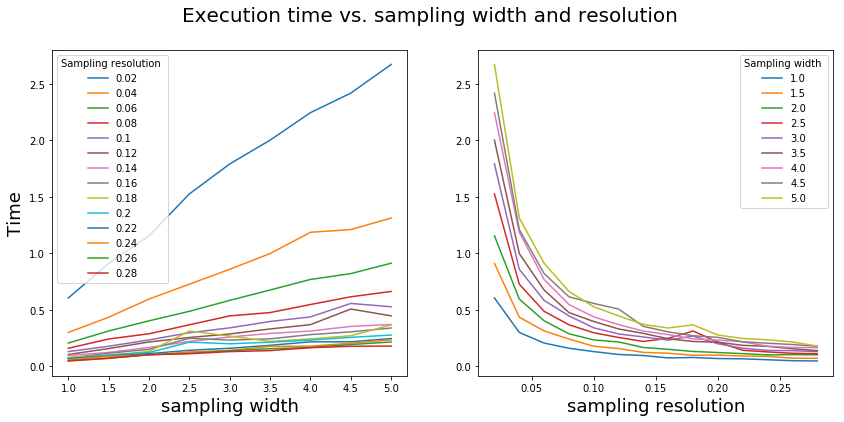

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
st = fig.suptitle("Execution time vs. sampling width and resolution", fontsize=20)

for r in samp_res:
    df = stat[stat.samp_resolution == r]
    line, = axes[0].plot(df.samp_width,df.time, label='Inline label')
    line.set_label( str(r))
    axes[0].legend(title ='Sampling resolution ')
    
for w in samp_width:
    df = stat[stat.samp_width == w]
    line, = axes[1].plot(df.samp_resolution,df.time) 
    line.set_label( str(w))
    axes[1].legend(title ='Sampling width ')
   
axes[0].set_ylabel('Time', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[0].set_xlabel('sampling width',fontsize=18)
axes[1].set_xlabel('sampling resolution', fontsize=18);

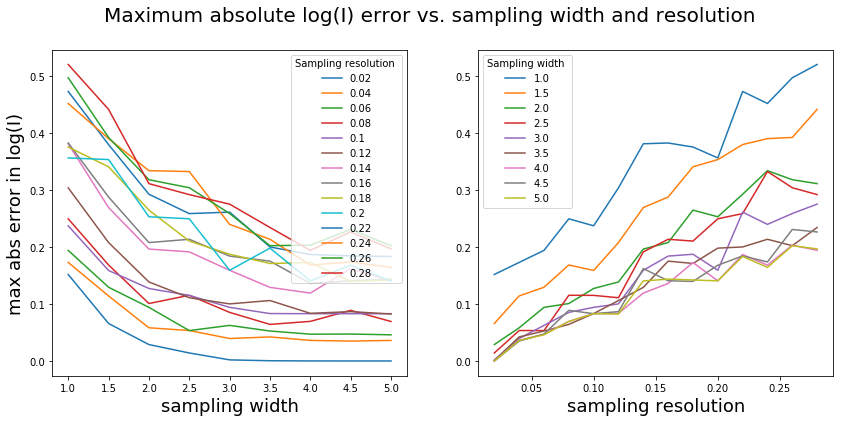

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
st = fig.suptitle("Maximum absolute log(I) error vs. sampling width and resolution", fontsize=20)

for r in samp_res:
    df = stat[stat.samp_resolution == r]
    line, = axes[0].plot(df.samp_width,df.max_abs_log_error, label='Inline label')
    line.set_label( str(r))
    axes[0].legend(title ='Sampling resolution ')
    
for w in samp_width:
    df = stat[stat.samp_width == w]
    line, = axes[1].plot(df.samp_resolution,df.max_abs_log_error) 
    line.set_label( str(w))
    axes[1].legend(title ='Sampling width ')

axes[0].set_ylabel('max abs error in log(I)', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[0].set_xlabel('sampling width',fontsize=18)
axes[1].set_xlabel('sampling resolution', fontsize=18);

#### Analyzing the data above, we choose a sampling width of 3.5 standard deviations, and a resolution of 0.1 standard deviations.

* The plots of "Execution time vs. sampling width and resolution" shows that execution time is increasing as sampling width is increasing and the execution time is decreasing as sampling resolution is increasing.

* The "Maximum absolute log(I) error vs. sampling width and resolution" plots show that sampling width more that 3.5 standard deviations does not decrease the max abs error in log(I). Thus, we have no reasons to use sampling width more than 3.5 standard deviations.

* Sampling resolution 0.1 gives us not the smallest, but reasonable small error. Choosing sampling resolution less than 0.1 leads to increasing exponential time exponentially.


#### The execution time is reduced by a factor of 5 to 10 (depends on computer):

In [10]:
I_new = []
t0 = time()
for r in r0:
    for s in sigma:
        I_new.append(spherical_normal_saxs(q,r,s,3.5,0.1))
print('time for computing spherical_normal_saxs()',
      'for all distributions, with new sampling:', 
      (time()-t0), "seconds.")

time for computing spherical_normal_saxs() for all distributions, with new sampling: 0.43079113960266113 seconds.


In [11]:
I = [] # I calculated with original coefficients
for r in r0:
    for s in sigma:
        I.append(spherical_normal_saxs(q,r,s, 5, 0.02))


max_abs_log_error = []
for i in range(n_samp):
    max_abs_log_error.append(max(np.log10(I[i]) - np.log10(I_new[i])))
    
np.mean(max_abs_log_error)

0.083269900322632692

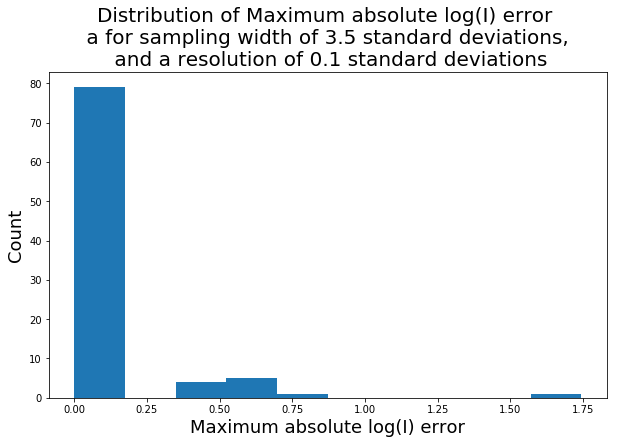

In [12]:
fig, axes = plt.subplots(figsize=(10,6))
plt.hist(max_abs_log_error)
plt.xlabel('Maximum absolute log(I) error', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of Maximum absolute log(I) error \n a for sampling width of 3.5 standard deviations, \n and a resolution of 0.1 standard deviations', fontsize=20)
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')